In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

import warnings 
warnings.filterwarnings("ignore")

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

2021-11-24 04:55:32.806720: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.
2021-11-24 04:55:33.372516: I tensorflow/core/platform/cpu_feature_guard.cc:145] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2021-11-24 04:55:33.395418: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3800180000 Hz
2021-11-24 04:55:33.396427: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561b787bccd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-24 04:55:33.396450: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-24 04:55:33.397370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-24 04:55:33.447564: I tensorflow/stream_executor/cuda/cuda_

### First: Install Kaggle API for download competition data.

In [4]:
DATA_DIR = './input'

# Directory to save logs and trained model
ROOT_DIR = './working'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [5]:
#!git clone https://www.github.com/matterport/Mask_RCNN.git
# os.chdir('Mask-RCNN')
#!python setup.py -q install

In [6]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [7]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

#### code

In [8]:
def get_dicom_fps(dicom_dir):
#     onlyfiles = [f for f in os.listdir(dicom_dir) if os.path.isfile(os.path.join(dicom_dir, f))]    
#     return onlyfiles
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [9]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [10]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [11]:
# training dataset
os.getcwd()
anns = pd.read_csv('./input/stage_2_train_labels.csv')
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


#### Here

In [12]:
%%time
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

CPU times: user 1.45 s, sys: 10.4 ms, total: 1.46 s
Wall time: 1.47 s


In [13]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [14]:
# show dicom fields 
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.22216.1517874439.522120
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.22216.1517874439.522120
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [15]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [16]:
# split dataset into training vs. validation dataset 
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25184 1500


### Create and prepare the training dataset using the DetectorDataset class.

In [17]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [18]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    239f7e39-e679-4892-9c87-04d1e4fd240f
 x                                           638.0
 y                                           598.0
 width                                       185.0
 height                                      138.0
 Target                                          1
 Name: 2054, dtype: object]

In [19]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
./input/stage_2_train_images/697491a0-2dfb-4d33-ace5-e824a637215f.dcm
[1]


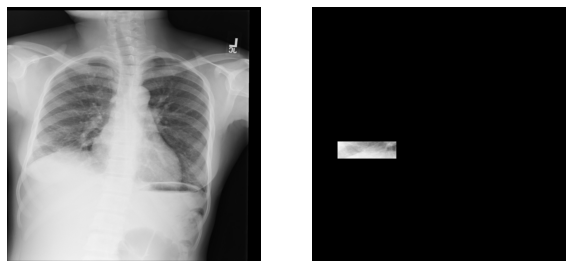

In [20]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

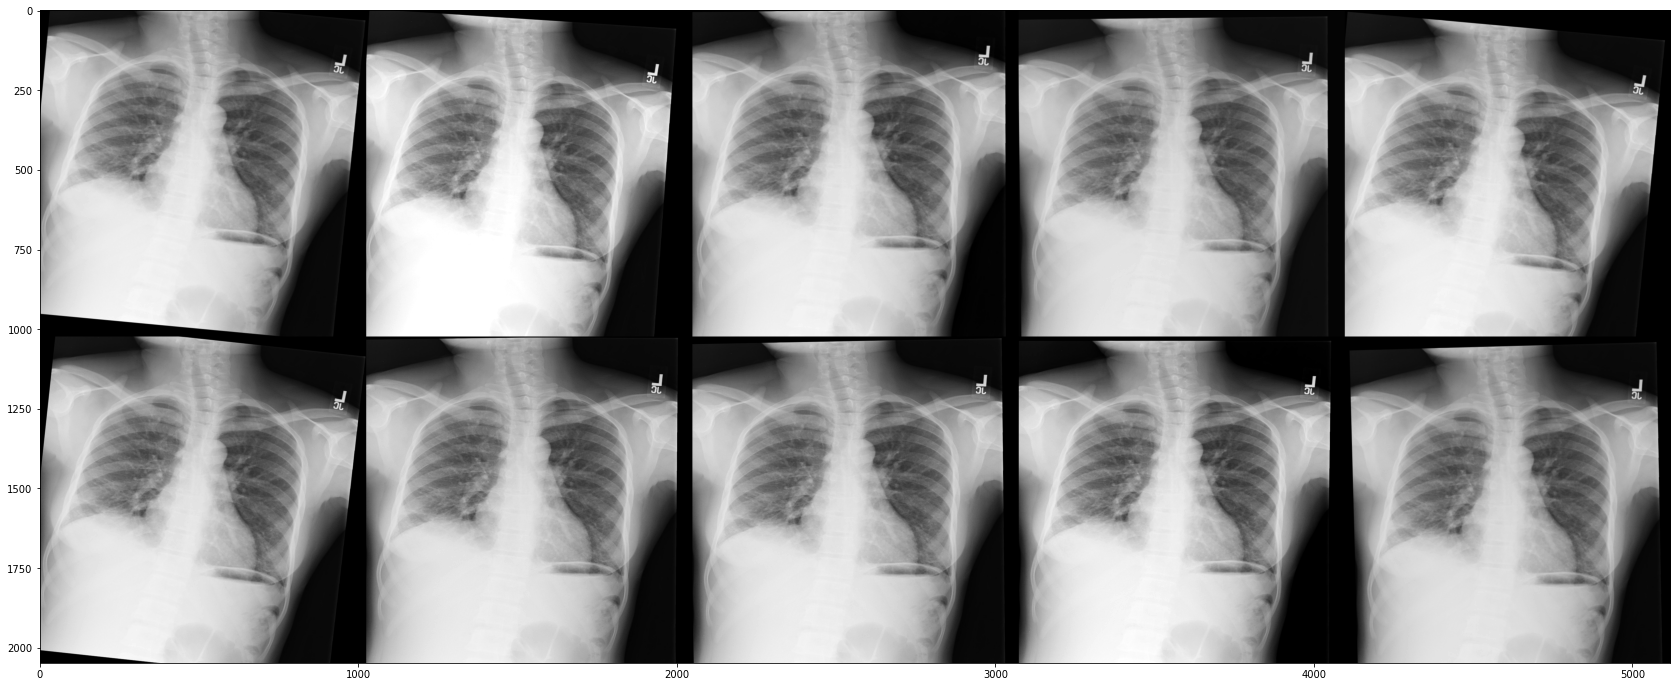

In [21]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.04), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.03, 0.03), "y": (-0.05, 0.05)},
            rotate=(-5, 5),
            shear=(-3, 3),
        ),
        iaa.PiecewiseAffine(scale=(0.002, 0.03)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.85, 1.15)),
        iaa.ContrastNormalization((0.85, 1.15)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.12)),
        iaa.Sharpen(alpha=(0.0, 0.12)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [22]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

In [23]:
NUM_EPOCHS = 50
LEARNING_RATE = 0.006

In [24]:
%%time
## first epochs with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='all',
            augmentation=None)  ## no need to augment yet


Starting at epoch 0. LR=0.012

Checkpoint Path: ./working/pneumonia20211124T0455/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b        

2021-11-24 04:58:36.224602: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-24 04:58:36.793290: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


200/200 [==============================] - 320s 2s/step - loss: 1.9090 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 0.4476 - mrcnn_class_loss: 0.3133 - mrcnn_bbox_loss: 0.5114 - mrcnn_mask_loss: 0.5258 - val_loss: 2.5353 - val_rpn_class_loss: 0.0843 - val_rpn_bbox_loss: 0.9283 - val_mrcnn_class_loss: 0.3853 - val_mrcnn_bbox_loss: 0.6607 - val_mrcnn_mask_loss: 0.4767
Epoch 2/2
200/200 [==============================] - 143s 717ms/step - loss: 1.3162 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.2408 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.3602 - mrcnn_mask_loss: 0.4382 - val_loss: 3.1468 - val_rpn_class_loss: 0.1343 - val_rpn_bbox_loss: 1.3045 - val_mrcnn_class_loss: 0.4786 - val_mrcnn_bbox_loss: 0.6290 - val_mrcnn_mask_loss: 0.6004
CPU times: user 8min 41s, sys: 1min 28s, total: 10min 9s
Wall time: 9min 14s


In [25]:
%%time
# Train Mask-RCNN Model 
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=NUM_EPOCHS,
            layers='all',
            augmentation=augmentation)


Starting at epoch 2. LR=0.006

Checkpoint Path: ./working/pneumonia20211124T0455/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b        

200/200 [==============================] - 177s 885ms/step - loss: 0.7671 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.3001 - val_loss: 2.6558 - val_rpn_class_loss: 0.0849 - val_rpn_bbox_loss: 0.7513 - val_mrcnn_class_loss: 0.5754 - val_mrcnn_bbox_loss: 0.4916 - val_mrcnn_mask_loss: 0.7525
Epoch 13/50
200/200 [==============================] - 171s 857ms/step - loss: 0.7165 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1456 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2785 - val_loss: 2.8312 - val_rpn_class_loss: 0.1434 - val_rpn_bbox_loss: 0.8552 - val_mrcnn_class_loss: 0.5589 - val_mrcnn_bbox_loss: 0.5385 - val_mrcnn_mask_loss: 0.7351
Epoch 14/50
200/200 [==============================] - 178s 888ms/step - loss: 0.7267 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.1544 - mrcnn_mask_loss: 0.2847 - val_loss: 2.3959 - val_rpn_class_l

200/200 [==============================] - 172s 862ms/step - loss: 0.5141 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.2068 - val_loss: 2.2769 - val_rpn_class_loss: 0.1035 - val_rpn_bbox_loss: 0.8209 - val_mrcnn_class_loss: 0.3639 - val_mrcnn_bbox_loss: 0.4704 - val_mrcnn_mask_loss: 0.5182
Epoch 34/50
200/200 [==============================] - 180s 900ms/step - loss: 0.4866 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.2040 - val_loss: 2.1878 - val_rpn_class_loss: 0.1095 - val_rpn_bbox_loss: 0.6757 - val_mrcnn_class_loss: 0.3594 - val_mrcnn_bbox_loss: 0.4786 - val_mrcnn_mask_loss: 0.5646
Epoch 35/50
200/200 [==============================] - 176s 879ms/step - loss: 0.4978 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.2061 - val_loss: 2.3701 - val_rpn_class_l

In [26]:
history = model.keras_model.history.history
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,3.059265,0.147187,1.084112,0.681508,0.618696,0.527745,1.365986,0.046106,0.288895,0.265326,0.339806,0.425836
2,2.586389,0.109155,1.000146,0.365299,0.571444,0.540329,1.020111,0.021090,0.173103,0.191783,0.256034,0.378085
3,2.578808,0.095520,1.095171,0.287712,0.615033,0.485355,0.989296,0.022692,0.192827,0.172128,0.241547,0.360085
4,2.511959,0.081449,0.988076,0.316773,0.588200,0.537444,0.839823,0.015308,0.152801,0.145793,0.194967,0.330936
5,2.529967,0.111940,1.173313,0.227915,0.426314,0.590468,0.801456,0.015470,0.153988,0.141337,0.175743,0.314900
6,3.239221,0.266396,1.750246,0.232321,0.456333,0.533908,0.829147,0.017255,0.161452,0.144039,0.187529,0.318854
7,2.577114,0.079930,0.839279,0.488173,0.519578,0.650137,0.762723,0.015935,0.162759,0.130425,0.163875,0.289712
8,3.416114,0.162539,1.511096,0.477066,0.571348,0.694046,0.791977,0.018562,0.166861,0.136201,0.175102,0.295233
9,2.766110,0.101037,0.847407,0.656823,0.519004,0.641820,0.759949,0.016094,0.168122,0.123034,0.160649,0.292031
10,2.655815,0.084933,0.751297,0.575435,0.491646,0.752484,0.767134,0.014205,0.148166,0.137694,0.166964,0.300085


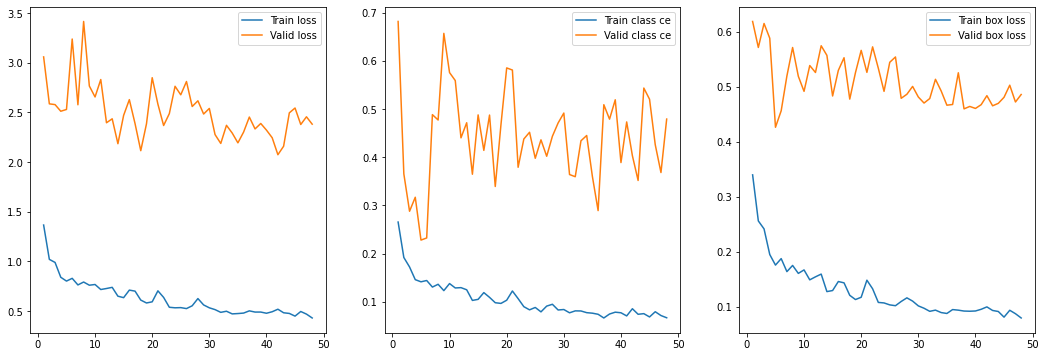

In [27]:

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()

# plt.figure(figsize=(10,10))
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()

# plt.figure(figsize=(10,10))
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

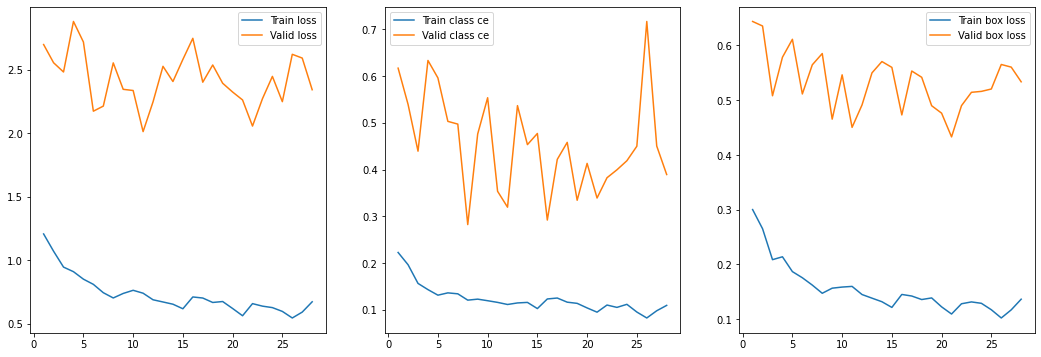

In [49]:

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()

# plt.figure(figsize=(10,10))
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()

# plt.figure(figsize=(10,10))
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [28]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 42 2.074174962043762


In [29]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in ./working/pneumonia20211121T0150
No weight files in ./working/pneumonia20211124T0409
No weight files in ./working/pneumonia20211124T0423
Found model ./working/pneumonia20211124T0455/mask_rcnn_pneumonia_0050.h5


In [31]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

#AJ
# model.load_weights(model_path, by_name=True,exclude=["conv1"])

Loading weights from  ./working/pneumonia20211124T0455/mask_rcnn_pneumonia_0050.h5
Re-starting from epoch 50


In [32]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 


*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 



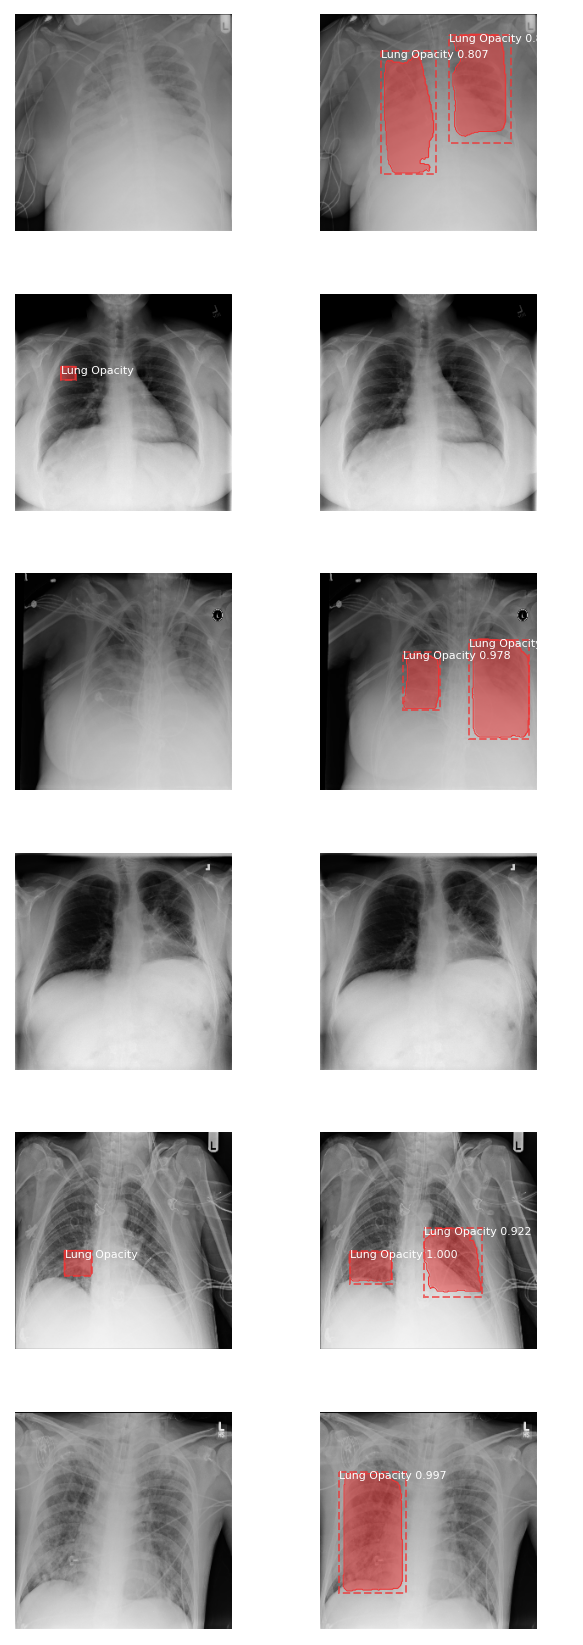

In [33]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    

In [34]:
%%time
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

CPU times: user 9.07 ms, sys: 795 µs, total: 9.87 ms
Wall time: 221 ms


### Final steps - Create the submission file

In [35]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.98):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [36]:
%%time
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:03<00:00, 16.36it/s]

./working/submission.csv
CPU times: user 4min 10s, sys: 4min 23s, total: 8min 34s
Wall time: 3min 3s


In [37]:
output = pd.read_csv(submission_fp, names=['patientId', 'PredictionString'])
output.head(30)

,patientId,PredictionString
0,patientId,PredictionString
1,241b5fc6-2e5e-4b62-a433-a15e16e44627,0.99 564.0 312.0 276.0 352.0
2,313f7f44-f566-40f2-bfec-54cc571b7344,NaN
3,0dd973cd-f375-447c-8c64-bc61a11ad0f7,1.0 264.0 268.0 232.0 444.0
4,21ef32bf-62fb-4868-b7a4-f29b21a5ede4,1.0 224.0 436.0 228.0 400.0
5,19fb7d5e-8ed4-4746-aac7-008b0b8ea700,0.98 260.0 228.0 224.0 244.0
6,2dde7f7c-84e3-4a24-a159-353377438e30,1.0 180.0 516.0 240.0 388.0
7,1d54fc4c-4642-433e-ae06-e595adb6c185,NaN
8,0ea77882-9a44-463b-9141-b8a714c83dd1,NaN
9,134db8e4-e78a-41a8-8d62-ba2414e3d63b,NaN


24a968f6-bd26-4ef1-90b7-ca75df777e56
[122 127 163 174]
x 508 y 488 h 188 w 164
1532c43a-028c-4d77-9cb0-f9d103988e7b
[ 98  48 169 116]
x 192 y 392 h 272 w 284
21a7dbab-2bdc-4656-b51b-7f9dba14e39c
[147  52 195 110]
x 208 y 588 h 232 w 192
10d51e48-d4c4-4a73-993d-0de2fd798444
[ 79  48 186 107]
x 192 y 316 h 236 w 428
[112 135 195 202]
x 540 y 448 h 268 w 332


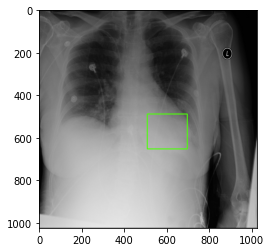

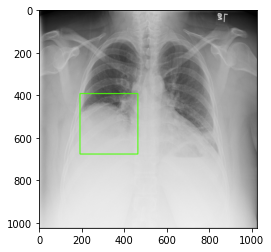

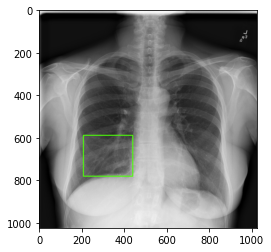

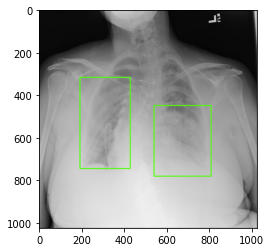

In [38]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()